# Network Visualization

This notebook loads a dataset and network and visualized the dataset features and subsequent network activations

In [1]:
import os
import tensorflow as tf
from Dataset import Dataset
import matplotlib.pyplot as plt
# custom functions for interactiva plotting
from utils.interactive_plotting import show, show_gray, show_rgb
# custom functions for writing pngs
from utils.interactive_plotting import norm_ptp, norm_std, norm_rgb, write, dump3, dump, dump_rgb, dump_class
import numpy as np
from PIL import Image
%matplotlib inline

tf.reset_default_graph()

modeldir="data_IJGI18/models/convlstm256_48px"

# None -> dont write output pngs
outfolder=None

datadir="data_IJGI18/datasets/demo/480"

## Initialize Dataset

If `RessourceExhaustedError` or `OutOfMemory` error occur later: reduce number ids in `overwrite_ids` and `batchsize`

In [2]:
# set specificly which ids should be returned (set none for random)
# tile ids from paper: 1823 8133 2550 2554 10791 10792 10879 10969 12894 16494 1272
overwrite_ids=[2550,10969]
batchsize=2

dataset = Dataset(datadir=datadir, 
                  verbose=True, 
                  temporal_samples=None, 
                  section="2016")

tfdataset, _, _, filenames = dataset.create_tf_dataset("eval",0,batchsize,True,2,overwrite_ids=overwrite_ids)
iterator = tfdataset.make_initializable_iterator()

overwriting data ids! due to manual input
dataset: 2016, partition: eval, fold:0 2/1944 tiles downloaded (0.10 %)


## Start TF Session and initialize iterators

In [3]:
config = tf.ConfigProto()
sess = tf.InteractiveSession()

data_handle = sess.run(iterator.string_handle())

#train_writer = tf.summary.FileWriter(os.path.join(args.modeldir, TRAINING_SUMMARY_FOLDER_NAME), sess.graph)
#test_writer = tf.summary.FileWriter(os.path.join(args.modeldir, TESTING_SUMMARY_FOLDER_NAME))

sess.run([iterator.initializer])

[None]

## Checkout input data from the iterator

In [4]:
sess.run([tf.global_variables_initializer(), tf.local_variables_initializer(), tf.tables_initializer()])

# run a network session with the operations defined prviously
x10,x20,x60,doy,year,labels = sess.run(iterator.get_next())

In [5]:
show_rgb(x10)
show_rgb(x20)
show_rgb(x60)
show_gray(labels[:,0,:,:],name="labels")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## load model graph definition (graph.meta)

In [6]:
graph=os.path.join(modeldir,"graph.meta")
tf.train.import_meta_graph(graph)

# initialize variables
sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

[None, None]

## restore weights from checkpoint (model.ckpt)

In [7]:
saver = tf.train.Saver(save_relative_paths=True)
checkpoint = os.path.join(modeldir, "model.ckpt")

latest_ckpt = tf.train.latest_checkpoint(modeldir)
if latest_ckpt is not None:
    print "restoring from " + latest_ckpt
    saver.restore(sess, latest_ckpt)

restoring from data_IJGI18/models/convlstm256_48px/model.ckpt-131650
INFO:tensorflow:Restoring parameters from data_IJGI18/models/convlstm256_48px/model.ckpt-131650


## List of all available operations within the model graph

In [8]:
sess.graph.get_operations()
# tf.trainable_variables()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'hash_table' type=HashTableV2>,
 <tf.Operation 'hash_table/Const' type=Const>,
 <tf.Operation 'key_value_init' type=InitializeTableV2>,
 <tf.Operation 'hash_table_1' type=HashTableV2>,
 <tf.Operation 'hash_table_1/Const' type=Const>,
 <tf.Operation 'key_value_init_1' type=InitializeTableV2>,
 <tf.Operation 'RandomShuffle/value' type=Const>,
 <tf.Operation 'RandomShuffle' type=RandomShuffle>,
 <tf.Operation 'compression_type' type=Const>,
 <tf.Operation 'buffer_size' type=Const>,
 <tf.Operation 'num_parallel_calls' type=Const>,
 <tf.Operation 'count' type=Const>,
 <tf.Operation 'Const_2' type=Const>,
 <tf.Operation 'Iterator' type=Iterator>,
 <tf.Operation 'TFRecordDataset' type=TFRecordDataset>,
 <tf.Operation 'ParallelMapDataset' type=ParallelMapDataset>,
 <tf.Operation 'RepeatDataset' type=RepeatDataset>,
 <tf.Operation 'BatchDataset/batch_size' type=Const>,
 <tf.Operation 'BatchDataset' type=Bat

## Retrieve operations from the graph

In [9]:
def get_op(name):
    return tf.get_default_graph().get_operation_by_name(name).outputs[0]

## get variables from tf.default_graph
iterator_handle_op = get_op("data_iterator_handle")
is_train_op = get_op("is_train")
global_step_op = get_op("global_step")
train_op = get_op("train_op")

# container to store operations to be obtained
query_map=dict()

#atrousdeep generation
query_map["x"]="input/reshaped/x"

query_map["convrnn_input"]="convrnn1/input"
query_map["convrnn_output"]="convrnn1/outputs"
query_map["convrnn_state"]="convrnn1/final_states"
    
query_map["targets"]="targets"
query_map["predictions"]="predictions"
query_map["prediction_scores"]="prediction_scores"
query_map["correctly_predicted"]="correctly_predicted"

## Inference - Execute the graph with data and store results in dict

In [10]:
feed = {iterator_handle_op:data_handle,is_train_op:False}

operations = ops = [get_op(query_map[key]) for key in sorted(query_map.keys())]

# run a network session with the operations defined prviously
queried = sess.run(operations,feed_dict=feed)

# build a results dict
results=dict()
for key, array in zip(sorted(query_map.keys()),queried):
    results[key]=array

In [11]:
print(results.keys())

['convrnn_input', 'predictions', 'convrnn_output', 'x', 'correctly_predicted', 'targets', 'prediction_scores', 'convrnn_state']


## Visualize Results

### Input

In [12]:
show_rgb(results["x"], name="x")
show_gray(results["targets"],name="labels")

A Jupyter Widget

A Jupyter Widget

## Sequence encoder input and output

In [13]:
show(results["convrnn_input"],name="convrnn_in")
show(results["convrnn_state"],name="states")

if outfolder is not None:
    dump3(array=results["convrnn_state"], name="final_state", outfolder=outfolder, cmap="inferno")
    dump3(array=results["prediction_scores"], name="prediction_scores", outfolder=outfolder, cmap="inferno")
#dump(array=results["convrnn_state"], name="final_state", outfolder=outfolder, cmap="inferno")

A Jupyter Widget

A Jupyter Widget

### Activations for each class (aka band)

In [14]:
show_gray(results["prediction_scores"],name="prediction scores")

A Jupyter Widget

### Predictions vs Ground truth

In [15]:
show_gray(results["predictions"],name="predictions",vmin=0,vmax=26)
show_gray(results["targets"],name="labels",vmin=0,vmax=26)

A Jupyter Widget

A Jupyter Widget

## Recreate LSTM iteration to access gate activations

also implemented in activations.py

try:
```
python activations.py --help
```
for more info

### Define the LSTM cell
see implementation in ```utils/convrnn/cell.py```

In [16]:
import utils.convrnn as convrnn
import numpy as np

b,t,px,px,d_in = results["convrnn_input"].shape

def convolution(inputs,W,data_format):
    """wrapper around tf.nn.convolution with custom padding"""
    pad_h = int(W.get_shape()[0])/2
    pad_w = int(W.get_shape()[1])/2

    paddings = tf.constant([[0, 0], [pad_h,pad_h], [pad_w,pad_w], [0, 0]])

    inputs_padded = tf.pad(inputs, paddings, "REFLECT")

    return tf.nn.convolution(inputs_padded, W, 'VALID', data_format=data_format)

def layer_norm(inputs,beta,gamma):
    """taken from contrib tf.contrib.layers.layer_norm definition in
    tensorflow/contrib/layers/python/layers/layers.py
    """
    mean, variance = tf.nn.moments(inputs, [1,2,3], keep_dims=True)
    outputs = tf.nn.batch_normalization(
        inputs, mean, variance, offset=beta, scale=gamma,
        variance_epsilon=1e-12)
    return outputs

x = results["convrnn_input"][:,0]

scope = "convrnn1/bidirectional_rnn/fw/conv_lstm_cell"


#state = sess.run(zero_state_op)

weights=[]
weights.append(get_op(scope+"/kernel"))
#weights.append(get_op(scope+"/W_ci")) # peephole
#weights.append(get_op(scope+"/W_cf")) # peephole
#weights.append(get_op(scope+"/W_co")) # peephole
weights.append(get_op(scope+"/LayerNorm/beta"))
weights.append(get_op(scope+"/LayerNorm/gamma"))
weights.append(get_op(scope+"/LayerNorm_1/beta"))
weights.append(get_op(scope+"/LayerNorm_1/gamma"))
weights.append(get_op(scope+"/LayerNorm_2/beta"))
weights.append(get_op(scope+"/LayerNorm_2/gamma"))
weights.append(get_op(scope+"/LayerNorm_3/beta"))
weights.append(get_op(scope+"/LayerNorm_3/gamma"))
weights.append(get_op(scope+"/LayerNorm_4/beta"))
weights.append(get_op(scope+"/LayerNorm_4/gamma"))

def lstm(x,state,weights, peephole=False, activation=tf.nn.tanh):
    """Implementation modified from carlthome/tensorflow-convlstm-cell"""

    if peephole:
        kernel, W_ci, W_cf, W_co, b_j, g_j, b_i, g_i, b_f, g_f, b_o, g_o, b_c, g_c = weights
    if not peephole:
        kernel, b_j, g_j, b_i, g_i, b_f, g_f, b_o, g_o, b_c, g_c = weights
    
    
    c,h = state
    x = tf.concat([x, h], axis=3).eval()
    n = x.shape[-1]
    m = 4 * convfilters if convfilters > 1 else 4
    y = convolution(x,kernel,data_format="NHWC").eval()
    #y = tf.nn.convolution(x, kernel, 'SAME', data_format="NHWC").eval()
    j, i, f, o = tf.split(y, 4, axis=3)

    if peephole:
        # peephole connections
        i += W_ci * c
        f += W_cf * c

    # normalize
    # replacement for tf.contrib.layers.layer_norm(j)
    #
    ## normalize in cell.py
    #j = tf.contrib.layers.layer_norm(j)
    #i = tf.contrib.layers.layer_norm(i)
    #f = tf.contrib.layers.layer_norm(f)
    #
    j = layer_norm(j,b_j,g_j)

    i = layer_norm(i,b_i,g_i)

    f = layer_norm(f,b_f,g_f)

    forget_bias=1
    f = tf.sigmoid(f + forget_bias)
    i = tf.sigmoid(i)
    c = c * f + i * activation(j)
    
    if peephole:
        o += W_co * c

    o = layer_norm(o,b_o,g_o)

    c = layer_norm(c,b_c,g_c)

    o = tf.sigmoid(o)
    h = o * activation(c)

    state = tf.nn.rnn_cell.LSTMStateTuple(c, h)

    return h,state,j,i,f,o


In [17]:
results["convrnn_output"].shape

(2, 46, 48, 48, 512)

### Perform Iteration on CPU

In [18]:
inputs = results["convrnn_input"]

b,t,px,px,d = results["convrnn_output"].shape
convfilters = d/2
zero_state_op = tf.contrib.rnn.LSTMStateTuple(c=tf.zeros(tf.TensorShape([b, px, px, convfilters])),h=tf.zeros(tf.TensorShape([b, px, px, convfilters])))
state=sess.run(zero_state_op)

jGate = []
iGate = []
fGate = []
oGate = []
outputs = []
states = []
statesh = []

# execute on cpu because ressource exhausted error on GPU
with tf.device('/cpu:0'):

    for time in range(0,t):
        print("time {}".format(time))

        h,state,j,i,f,o = lstm(inputs[:,time],state, weights)
        state = tf.contrib.rnn.LSTMStateTuple(c=state.c.eval(),h=state.h.eval())

        #show_gray(i.eval(),"input_gate at t{}".format(it))

        iGate.append(i.eval())
        jGate.append(j.eval())
        fGate.append(f.eval())
        oGate.append(o.eval())
        outputs.append(h.eval())
        states.append(state.c)
        statesh.append(state.h)

iGate = np.stack(iGate,axis=1)
jGate = np.stack(jGate,axis=1)
fGate = np.stack(fGate,axis=1)
oGate = np.stack(oGate,axis=1)
outputs = np.stack(outputs,axis=1)
states = np.stack(np.array(states),axis=1)
statesh = np.stack(np.array(statesh),axis=1)

time 0
time 1
time 2
time 3
time 4
time 5
time 6
time 7
time 8
time 9
time 10
time 11
time 12
time 13
time 14
time 15
time 16
time 17
time 18
time 19
time 20
time 21
time 22
time 23
time 24
time 25
time 26
time 27
time 28
time 29
time 30
time 31
time 32
time 33
time 34
time 35
time 36
time 37
time 38
time 39
time 40
time 41
time 42
time 43
time 44
time 45


### Show Results

In [19]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np

def show_activations(arrays_tuple, titles=[""]):
    
    max_b, max_t,_,_,max_d = arrays_tuple[1].shape
    max_d=10
        
    def _show_map_BTHWD(t,d,b): 
        n = len(arrays_tuple)
        
        fig,axs = plt.subplots(1,n,figsize=(16,6))
        
        for array,ax,title in zip(arrays_tuple,axs,titles): 
            ax.imshow(array[b,t,:,:,d-1:d+2])
            ax.set_title(title)
            #_show(array[b,t,:,:,d],"{name} feature map b={b}, t={t}, d={d}".format(name=name,b=b,t=t,d=d))
    
    # all
    b_slider = widgets.IntSlider(description='batch',min=0,max=max_b-1,step=1,value=max_b/2)
         
    d_slider = widgets.IntSlider(description='band',min=1,max=max_d-1,step=1,value=max_d/2) 
    t_slider = widgets.IntSlider(description='time',min=0,max=max_t-1,step=1,value=max_t/2)
    w = interactive(_show_map_BTHWD, t=t_slider, d=d_slider, b=b_slider)
    
    w.layout.height = '400px'
    display(w)
   
#show(,"x")
def norm(arr,thresmin=-1,thresmax=1):
    arr[arr<thresmin]=thresmin
    arr[arr>thresmax]=thresmax
    return ( (arr-arr.min()) / (arr-arr.min()).max()).astype('float')

show_activations([iGate,oGate,norm(jGate),fGate,norm(states),norm(statesh),norm(outputs)],titles=["i","o","j","f","state","stateh","output"])
show(results["x"])
show_gray(states)
show_gray(statesh)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [20]:
show_rgb(results["x"], name="x")
show_gray(iGate,"input")
show_gray(fGate,"forget")
show_gray(states,"states")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## Write Arrays to png files

folder structure
``
{outfolder}/sample{s}/time{t}/{d}_{name}.png
``

with `s` as sample in batch, `t` as time, `d` as number of feature map and `name` `iGate`,`jGate`,`oGate`, etc.

In [21]:
if outfolder is not None:

    cmap="inferno"

    dump_rgb(results["x"][:,:,:,:,0:3],"x",outfolder,stddev=4)

    dump(array=iGate, name="iGate", outfolder=outfolder, cmap="inferno")
    dump(array=fGate, name="fGate", outfolder=outfolder, cmap="inferno")
    dump(array=oGate, name="oGate", outfolder=outfolder, cmap="inferno")
    dump(array=(jGate/2)+0.5, name="jGate", outfolder=outfolder, cmap="RdBu_r")
    dump(array=(statesh/2)+0.5, name="output", outfolder=outfolder, cmap="RdBu_r")
    dump(array=(states/2)+0.5, name="state", outfolder=outfolder, cmap="RdBu_r")

    dump_class(results["targets"],"ground_truth",outfolder)
    dump_class(results["predictions"],"predictions",outfolder)
    for i in range(0,17):
        dump_class(results["prediction_scores"][:,:,:,i],"prediction_scores_"+str(i),outfolder)

In [22]:
results["prediction_scores"].shape

(2, 48, 48, 17)

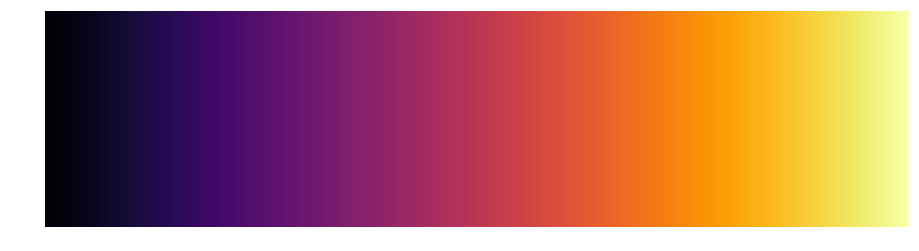

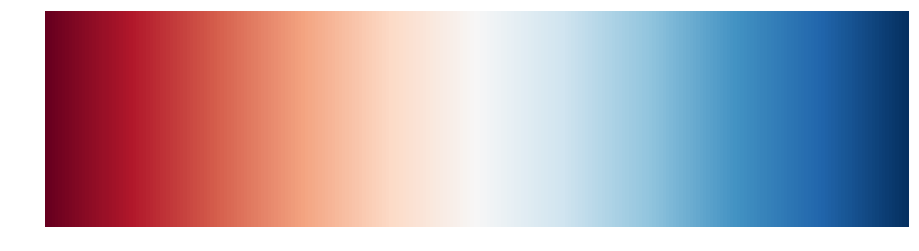

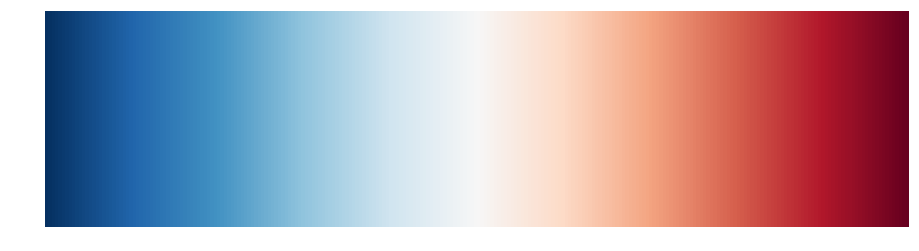

In [23]:
def plot_color_gradients(name, filename="tmp/test.png",w=8,h=2):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(w,h)
    #fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))

    ax.set_axis_off()
        
    plt.savefig(filename)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

if not os.path.exists("tmp"):
    os.makedirs("tmp")

plot_color_gradients("inferno", w=12,h=3,filename=os.path.join("tmp","inferno.png"))
plot_color_gradients("RdBu", w=12,h=3,filename=os.path.join("tmp","RdBu.png"))
plot_color_gradients("RdBu_r", w=12,h=3,filename=os.path.join("tmp","RdBu_r.png"))